In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib widget
import os
import sys
import importlib
import glob
from scipy.signal import find_peaks


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools
import bode_tools
import DREAM_colors as dc
import math_functions as mf
import BodeClass_PSI as bc
import ExperimentClass as ec

importlib.reload(tools)
importlib.reload(mf)
importlib.reload(bc)
importlib.reload(ec)
importlib.reload(dc)


<module 'DREAM_colors' from 'c:\\Users\\Orlando\\Desktop\\DREAM_repo\\DREAM_colors.py'>

In [59]:
import ast
import re

def fix_number_format(value):
    if isinstance(value, str):
        # Add a comma after an integer followed by a float
        value = re.sub(r'(\d+)\.\s+(\d)', r'\1., \2', value)
        
        # Add commas between numbers wherever necessary
        value = re.sub(r'(?<=\d)\s+(?=[\d\.])', ', ', value)
    return value

def convert_to_list(value):
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)
        except Exception as e:
            print(f"Error converting value: {value}, error: {e}")
            return value
    return value

# Apply this function to the relevant columns
columns_to_convert = ['F_max', 'F_stat', 'phi_stat', 'NPQ', 'ETR']

In [60]:
PSI_folder = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/PSI"
list_path = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/PSI/00_experiments_lists/"
bode_list = pd.read_csv(list_path + "00_bode_phaeo_list.csv", sep=";", decimal=",")
activation_list = pd.read_csv(list_path + "phaeo_activation_curve_list.csv", sep=";", decimal=",")

strain_to_color = {
    "Pt1-1": "C0",
    "Pt1-3": "C1",
    "Pt1-26": "C2",
    "Pt1-27": "C3",
    "Pt1-11": "C4",
    "Pt1-43": "C5",
    "WT": "C0",
    "KO6": "C1",
    "LtpM": "C2",
}

In [61]:
fig_folder = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/Figures_analysis/20241202_bode_plot_phaeo/"
record_list = ["P0.015625s", "P0.03125s", "P0.0625s", "P0.125s", "P0.25s", "P0.5s", "P1s", "P2s", "P4s", "P8s", "P16s", "P32s", "P64s", "P128s"]
period_list = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
frequency_list = [1/period for period in period_list]
ref = ec.Experiment("20240919_ref_AL_data", "PSI", DataType = ".csv", sep = ';')
t_start = np.array([0.0985, 0.146, 0.244, 0.437, 0.826, 1.6, 3.1, 6.2, 12.4, 24.8, 49.65, 99.2, 198.4, 396.8])
t_end = np.array([31.2906, 62.5626, 125.1378, 200.2624, 200.6252, 201.35, 201.801, 204.8, 409.6, 417.6, 835.2, 867.2, 896, 1992.2])
pre_illumination_time = 60

real_f = np.array([6.37307153e+01, 3.18654251e+01, 1.59327462e+01, 7.96647276e+00,
       3.98348555e+00, 1.99199199e+00, 9.96477101e-01, 4.97987928e-01,
       2.48993964e-01, 1.24491870e-01, 6.22459350e-02, 3.11203320e-02,
       1.56250000e-02, 7.81250000e-03])

In [62]:
for i in range(len(ref.clean_data)):
    ref.clean_data[i] = ref.clean_data[i]*130 + 217

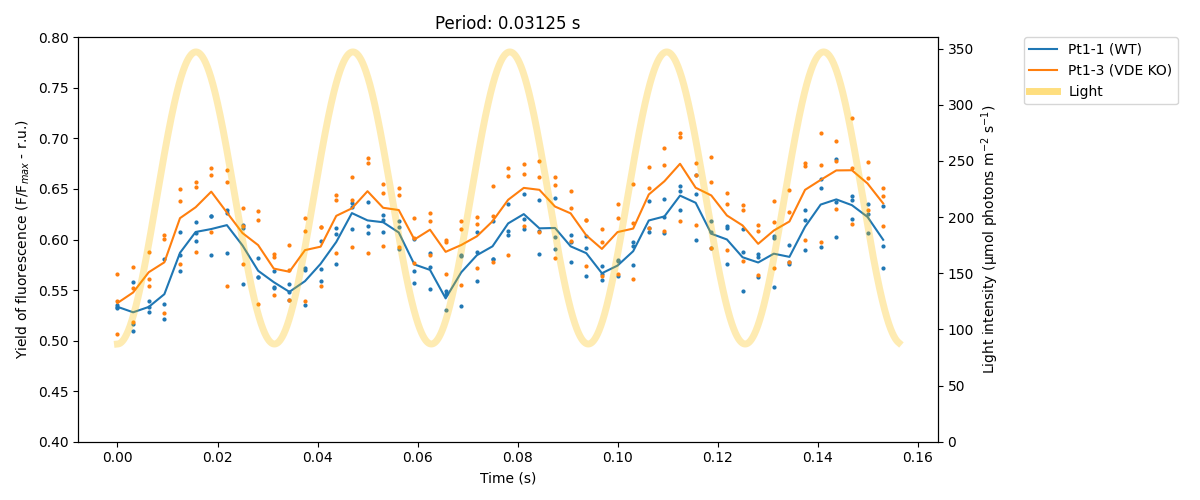

In [63]:
importlib.reload(mf)

strains = ["Pt1-1", "Pt1-3"]
# strains = ["Pt1-3"]
per_to_show = 5
period =0.03125
fig, ax = plt.subplots(figsize=(12, 5))

yellow = [255/256, 192/256, 0/256]
ax2 = ax.twinx()
index_ref = ref.records.index(f"P{period}s")
xfit = np.linspace(ref.clean_times[index_ref][0], ref.clean_times[index_ref][per_to_show*10], 100000)
yfit = mf.sinusoid(xfit, 130, real_f[tools.closest_index(real_f, 1/period)], -np.pi/2, 217)
ax2.plot(xfit,yfit, color = yellow, linewidth=5, alpha=0.3)
ax2.set_ylabel("Light intensity (µmol photons m$^{-2}$ s$^{-1}$)")
ax2.set_ylim(0, 360)

for i, strain in enumerate(strains):
    if strain == "Pt1-1":
        names = bode_list[(bode_list["Strain"] == strain) & (bode_list["Replicate"]!=1)]["Name"].to_list()
    else:
        names = bode_list[bode_list["Strain"] == strain]["Name"].to_list()
    bode_data = []
    bode_times = []
    for name in names:
        F_max_norm = bode_list[bode_list["Name"] == name]["F_max"].values[0]
        exp = ec.Experiment(name, "PSI", DataType = ".csv", sep = ';')
        index_list = record_list.index(f"P{period}s")
        index_exp = exp.records.index(f"P{period}s")
        ind_start = tools.closest_index(exp.clean_times[index_exp], t_start[index_list] + pre_illumination_time) -1
        ind_end = tools.closest_index(exp.clean_times[index_exp], t_end[index_list] + pre_illumination_time)
        bode_data.append(exp.clean_data[index_exp][ind_start:ind_end]/F_max_norm)
        bode_times.append(exp.clean_times[index_exp][ind_start:ind_end] - exp.clean_times[index_exp][ind_start])
        ax.plot(bode_times[-1][:per_to_show*10], bode_data[-1][:per_to_show*10], 'o', markersize=2, color = strain_to_color[strain])
    bode_data = np.array(bode_data)
    label = f"{strain} ({bode_list[bode_list['Name'] == name]['Label'].values[0]})"
    ax.plot(bode_times[-1][:per_to_show*10], np.mean(bode_data, axis=0)[:per_to_show*10], '-', markersize=2, label = label, color = strain_to_color[strain])

ax.plot([], [], color = yellow, label = "Light", linewidth=5, alpha=0.5 )
ax.set_ylabel("Yield of fluorescence (F/F$_{max}$ - r.u.)")
ax.set_xlabel("Time (s)")
ax.set_ylim(0.4, 0.8)
ax.set_title(f"Period: {period} s")
ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()


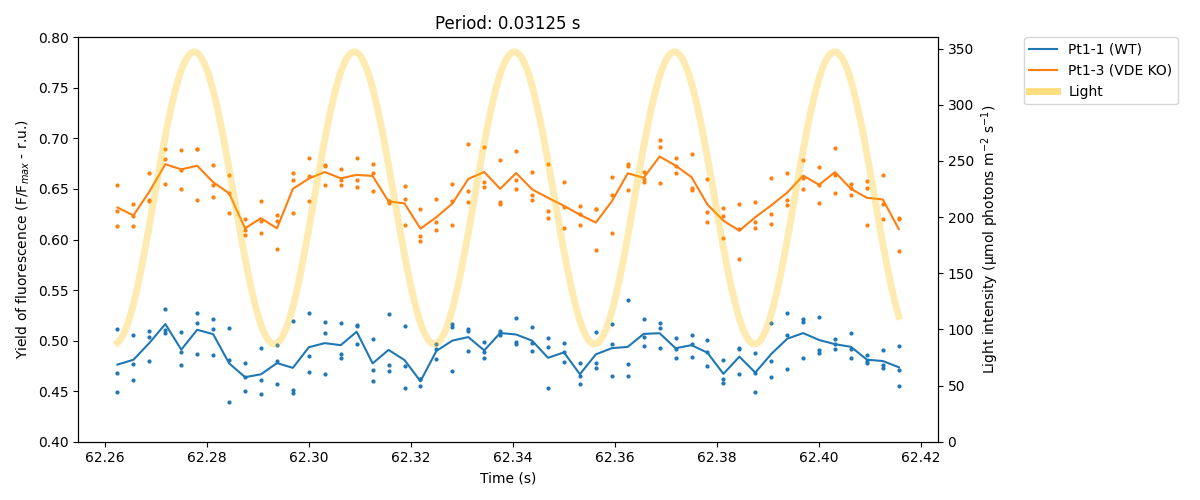

In [64]:
importlib.reload(mf)

strains = ["Pt1-1", "Pt1-3"]
# strains = ["Pt1-3"]
per_to_show = 5
period =0.03125
fig, ax = plt.subplots(figsize=(12, 5))

yellow = [255/256, 192/256, 0/256]
ax2 = ax.twinx()
index_ref = ref.records.index(f"P{period}s")
xfit = np.linspace(ref.clean_times[index_ref][-per_to_show*10], ref.clean_times[index_ref][-1], 100000)
yfit = mf.sinusoid(xfit, 130, real_f[tools.closest_index(real_f, 1/period)], -np.pi/2, 217)
ax2.plot(xfit,yfit, color = yellow, linewidth=5, alpha=0.3)
ax2.set_ylabel("Light intensity (µmol photons m$^{-2}$ s$^{-1}$)")
ax2.set_ylim(0, 360)

for i, strain in enumerate(strains):
    if strain == "Pt1-1":
        names = bode_list[(bode_list["Strain"] == strain) & (bode_list["Replicate"]!=1)]["Name"].to_list()
    else:
        names = bode_list[bode_list["Strain"] == strain]["Name"].to_list()
    bode_data = []
    bode_times = []
    for name in names:
        F_max_norm = bode_list[bode_list["Name"] == name]["F_max"].values[0]
        exp = ec.Experiment(name, "PSI", DataType = ".csv", sep = ';')
        index_list = record_list.index(f"P{period}s")
        index_exp = exp.records.index(f"P{period}s")
        ind_start = tools.closest_index(exp.clean_times[index_exp], t_start[index_list] + pre_illumination_time) -1
        ind_end = tools.closest_index(exp.clean_times[index_exp], t_end[index_list] + pre_illumination_time)
        bode_data.append(exp.clean_data[index_exp][ind_start:ind_end]/F_max_norm)
        bode_times.append(exp.clean_times[index_exp][ind_start:ind_end] - exp.clean_times[index_exp][ind_start])
        ax.plot(bode_times[-1][-per_to_show*10:], bode_data[-1][-per_to_show*10:], 'o', markersize=2, color = strain_to_color[strain])
    bode_data = np.array(bode_data)
    label = f"{strain} ({bode_list[bode_list['Name'] == name]['Label'].values[0]})"
    ax.plot(bode_times[-1][-per_to_show*10:], np.mean(bode_data, axis=0)[-per_to_show*10:], '-', markersize=2, label = label, color = strain_to_color[strain])

ax.plot([], [], color = yellow, label = "Light", linewidth=5, alpha=0.5 )
ax.set_ylabel("Yield of fluorescence (F/F$_{max}$ - r.u.)")
ax.set_xlabel("Time (s)")
ax.set_ylim(0.4, 0.8)
ax.set_title(f"Period: {period} s")
ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()


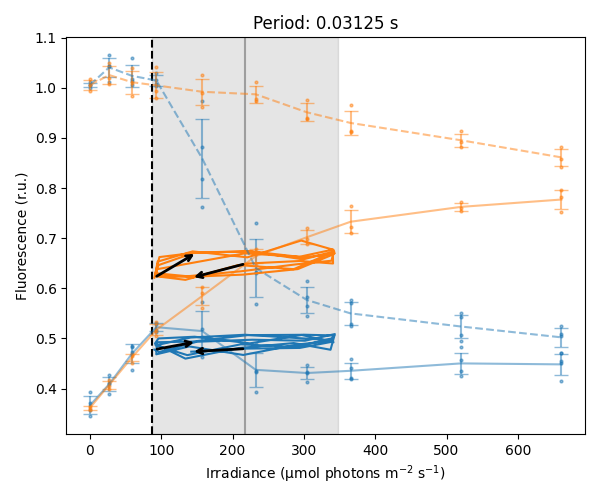

In [65]:
marker = 2
alpha_fstat = 0.5
Ek_offset = 2.5
Ek_amp = 1.5

plot_oscillations = True
arrows = True

periods = period_list
periods = [0.03125]

for k, period in enumerate(periods):

    strains = ["Pt1-1", "Pt1-3"]
    # strains = ["Pt1-3"]
    fig, ax = plt.subplots(figsize=(6, 5))

    all_ETR = []
    labels = []

    for i, strain in enumerate(strains):
        names = activation_list[(activation_list["Strain"] == strain) & (activation_list["Final protocol"] == "yes")]["Name"].to_list()
        labels.append(strain + f"({activation_list[activation_list.Name == names[0]]['Label'].values[0]})")

        ETR = []
        F_stat = []
        F_max = []
        
        for name in names:
            path = f"{PSI_folder}/{name}/params.csv"
            params = pd.read_csv(path, index_col= False, sep=";")
            for column in columns_to_convert:
                params[column] = params[column].apply(fix_number_format)
                params[column] = params[column].apply(convert_to_list)
            ETR.append([params.ETR[k][3] for k in params.index])
            F_stat.append([params.F_stat[k][3] for k in params.index])
            F_max.append([params.F_max[k][3] for k in params.index])
        
            ax.plot(params.Actinic, F_stat[-1], 'o', markersize = marker, alpha = alpha_fstat, color = strain_to_color[strain])
            ax.plot(params.Actinic, F_max[-1], 'o', markersize = marker, alpha = alpha_fstat, color = strain_to_color[strain])
        
        
        all_ETR.append(ETR)
        ETR = np.array(ETR)
        F_stat = np.array(F_stat)
        F_max = np.array(F_max)
        

        ax.errorbar(params.Actinic, F_stat.mean(axis=0), yerr = F_stat.std(axis=0), fmt = '-', color = strain_to_color[strain], label = labels[i], capsize = 5, alpha = alpha_fstat)
        ax.errorbar(params.Actinic, F_max.mean(axis=0), yerr = F_max.std(axis=0), fmt = '--', color = strain_to_color[strain], capsize = 5, alpha = alpha_fstat)
        
    all_data_array = np.array([replicate for condition in all_ETR for replicate in condition])
    average = np.mean(all_data_array, axis = 0)
    # ax2 = ax.twinx()
    # ax2.errorbar(params.Actinic, average, yerr = all_data_array.std(axis=0), fmt = '-', color = "k", capsize = 5)
    # ax2.set_ylabel("rETR")
    popt, pcov, xfit, yfit = tools.Ek_fit(params.Actinic[:7], average[:7], 0, 700, 100, p0=[100, 100])
    Ek = popt[0]


    ylim = ax.get_ylim()
    ax.axvline(Ek, color = "k", linestyle = "--", label = "$E_k$")
    ax.axvline(Ek*Ek_offset, color = "gray", linestyle = "-", alpha = 0.7)
    ax.fill_betweenx(ylim, Ek*Ek_offset - Ek*Ek_amp, Ek*Ek_offset + Ek*Ek_amp, color = "k", alpha = 0.1)
    ax.errorbar([], [], yerr = [], fmt = '-', color = "k", capsize = 5, label = "rETR")
    ax.set_ylim(ylim)
    ax.set_xlabel("Irradiance (µmol photons m$^{-2}$ s$^{-1}$)")
    ax.set_ylabel("Fluorescence (r.u.)")

    if plot_oscillations == True:

        per_to_show = 4
        # period = 0.015625
        for i, strain in enumerate(strains):
            if strain == "Pt1-1":
                names = bode_list[(bode_list["Strain"] == strain) & (bode_list["Replicate"]!=1)]["Name"].to_list()
            elif strain == "Pt1-3":
                names = bode_list[(bode_list["Strain"] == strain) & (bode_list["Replicate"]!=1)]["Name"].to_list()
            else:
                names = bode_list[bode_list["Strain"] == strain]["Name"].to_list()
            
            bode_data = []
            bode_times = []
            for name in names:
                F_max_norm = bode_list[bode_list["Name"] == name]["F_max"].values[0]
                exp = ec.Experiment(name, "PSI", DataType = ".csv", sep = ';')
                index_list = record_list.index(f"P{period}s")
                index_exp = exp.records.index(f"P{period}s")
                ind_start = tools.closest_index(exp.clean_times[index_exp], t_start[index_list] + pre_illumination_time)
                ind_end = tools.closest_index(exp.clean_times[index_exp], t_end[index_list] + pre_illumination_time)
                bode_data.append(exp.clean_data[index_exp][ind_start:ind_end]/F_max_norm)
                bode_times.append(exp.clean_times[index_exp][ind_start:ind_end] - exp.clean_times[index_exp][ind_start])
                # ax.plot(ref.clean_data[index_list][-per_to_show*10:], bode_data[-1][-per_to_show*10:], 'o', markersize=2, color = strain_to_color[strain]))
            bode_data = np.array(bode_data)
            light = ref.clean_data[index_list][-per_to_show*10:]
            fluo = np.mean(bode_data, axis=0)[-per_to_show*10:]
            ax.plot(light, np.mean(bode_data, axis=0)[-per_to_show*10:], '-', markersize=2, color = strain_to_color[strain])
            if arrows == True:
                ax.annotate("", xy=(light[0], fluo[0]), xytext=(light[2], fluo[2]), arrowprops=dict(arrowstyle="<-", linewidth=2))
                ax.annotate("", xy=(light[-2], fluo[-2]), xytext=(light[-1], fluo[-1]), arrowprops=dict(arrowstyle="<-", linewidth=2))

    # ax.legend(loc='center right')
    ax.set_title(f"Period: {period} s")
    fig.tight_layout()

    fig.savefig(f"{fig_folder}phase_space_{k}_{period}s.png", dpi=300)




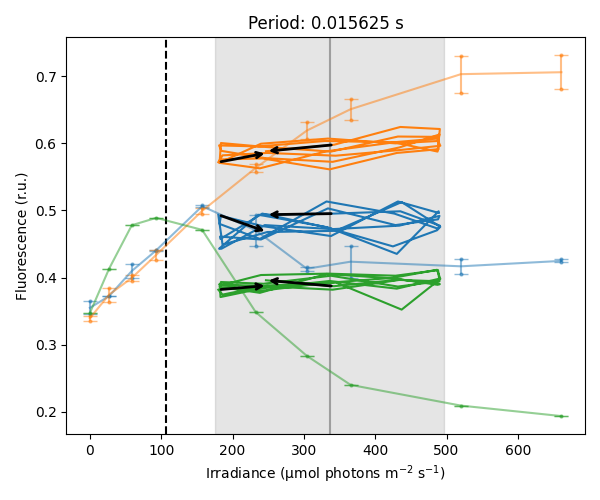

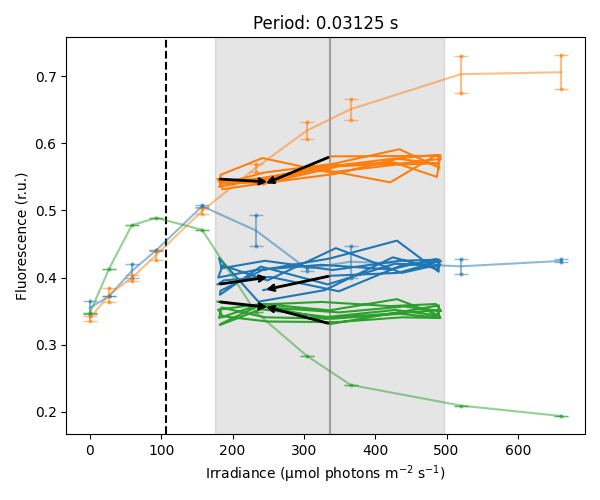

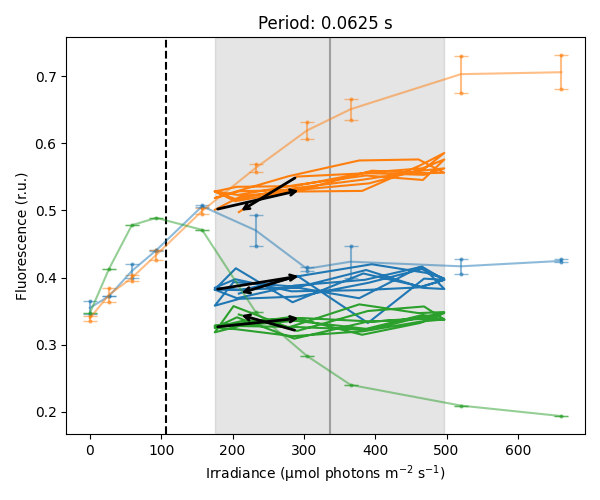

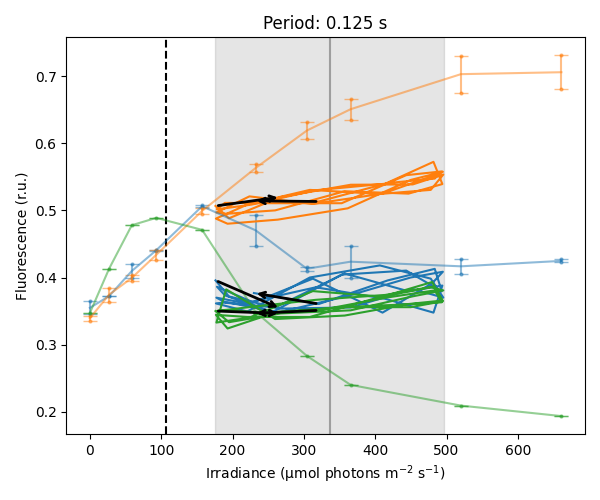

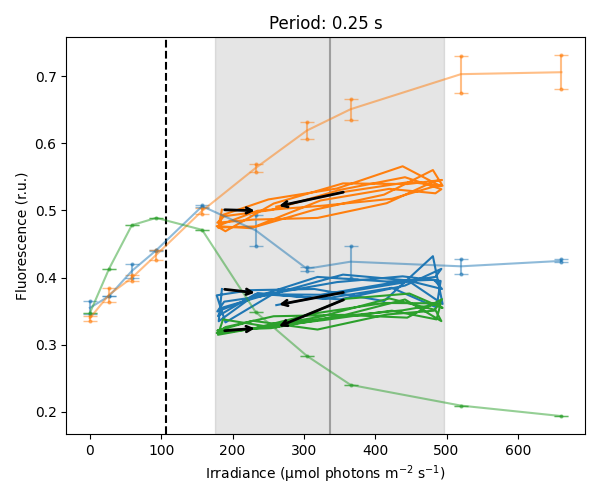

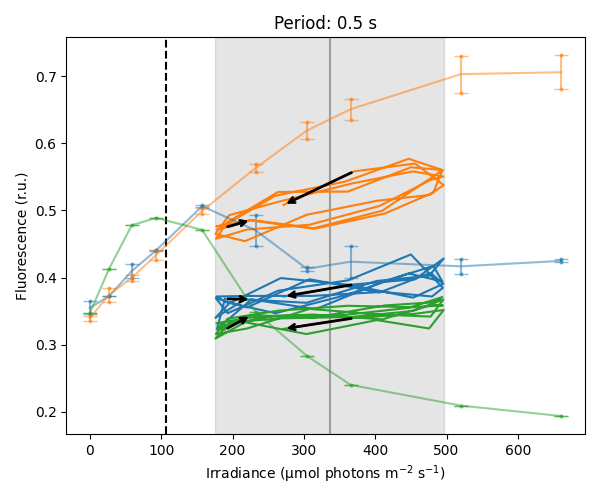

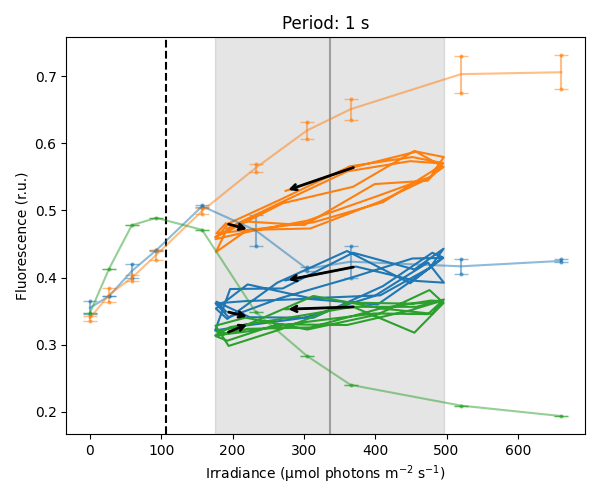

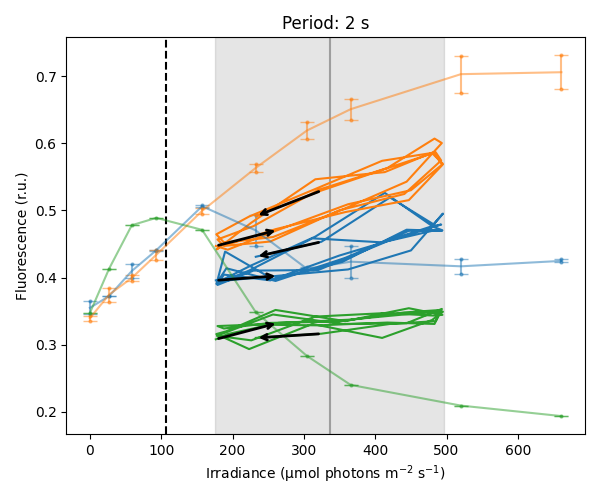

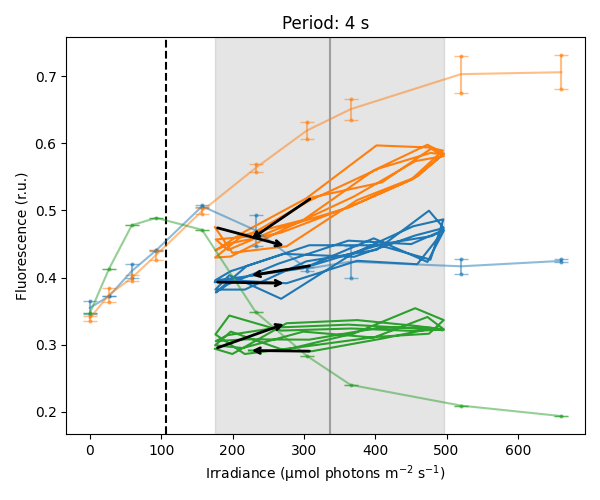

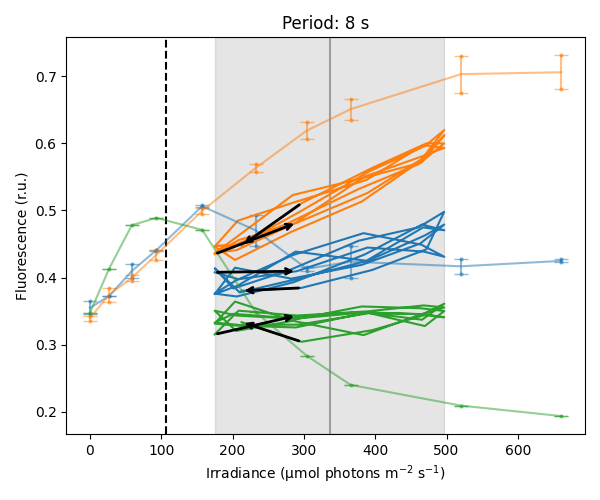

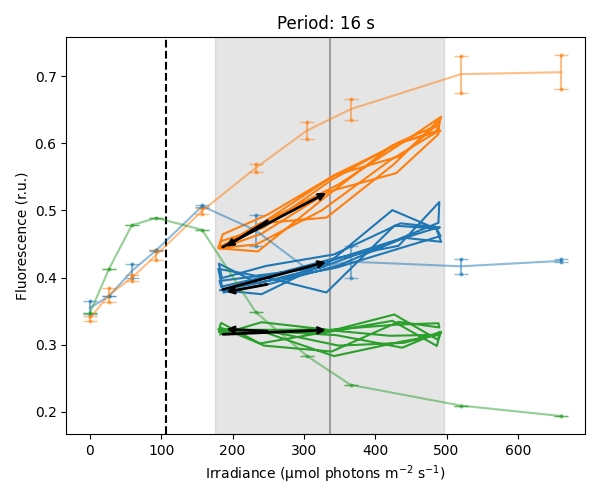

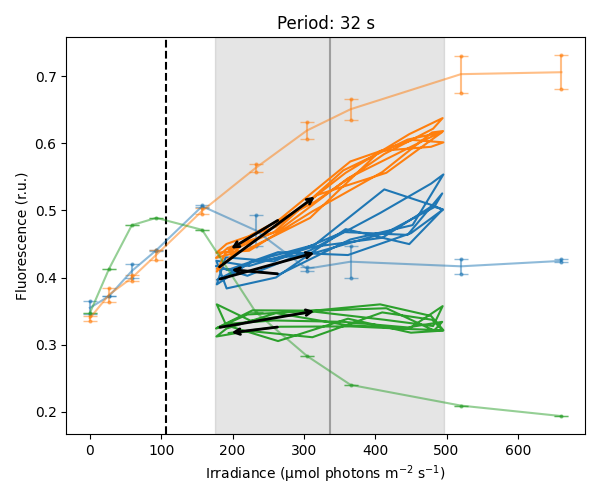

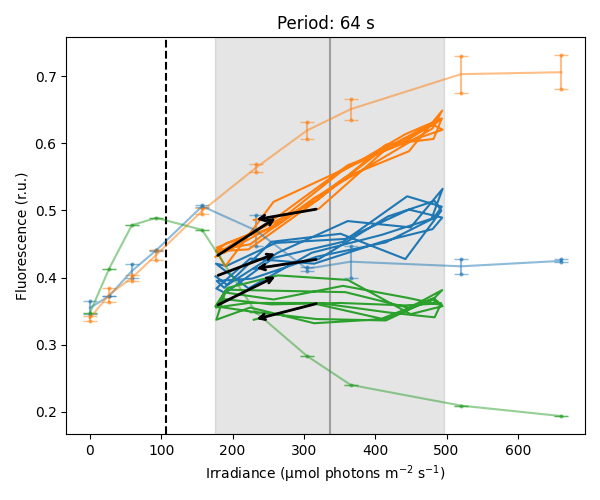

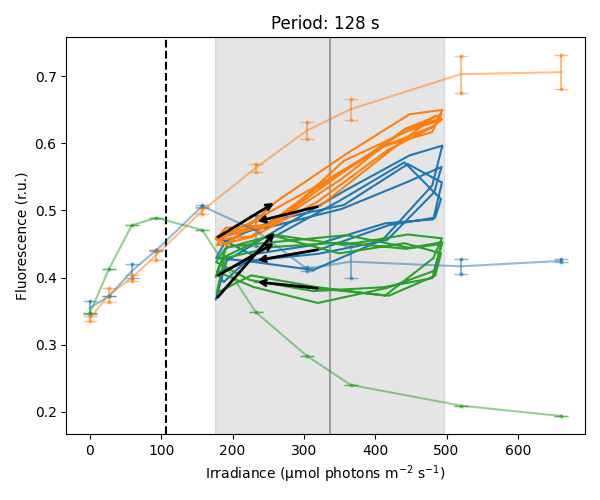

In [70]:
ref = ec.Experiment("20240919_ref_AL_data", "PSI", DataType = ".csv", sep = ';')

marker = 2
alpha_fstat = 0.5
Ek_offset = 3.13
Ek_amp = 1.5

plot_oscillations = True
arrows = True

periods = period_list
# periods = [0.03125]

for k, period in enumerate(periods):

    strains = ["WT", "KO6", "LtpM"]
    fig, ax = plt.subplots(figsize=(6, 5))

    all_ETR = []
    labels = []

    for i, strain in enumerate(strains):
        names = activation_list[(activation_list["Strain"] == strain) & (activation_list["Final protocol"] == "yes")]["Name"].to_list()
        labels.append(strain + f"({activation_list[activation_list.Name == names[0]]['Label'].values[0]})")

        ETR = []
        F_stat = []
        F_max = []
        
        for name in names:
            path = f"{PSI_folder}/{name}/params.csv"
            params = pd.read_csv(path, index_col= False, sep=";")
            for column in columns_to_convert:
                params[column] = params[column].apply(fix_number_format)
                params[column] = params[column].apply(convert_to_list)
            ETR.append([params.ETR[k][3] for k in params.index])
            F_stat.append([params.F_stat[k][3] for k in params.index])
            F_max.append([params.F_max[k][3] for k in params.index])
        
            ax.plot(params.Actinic, F_stat[-1], 'o', markersize = marker, alpha = alpha_fstat, color = strain_to_color[strain])
            # ax.plot(params.Actinic, F_max[-1], 'o', markersize = marker, alpha = alpha_fstat, color = strain_to_color[strain])
        
        
        all_ETR.append(ETR)
        ETR = np.array(ETR)
        F_stat = np.array(F_stat)
        F_max = np.array(F_max)
        

        ax.errorbar(params.Actinic, F_stat.mean(axis=0), yerr = F_stat.std(axis=0), fmt = '-', color = strain_to_color[strain], label = labels[i], capsize = 5, alpha = alpha_fstat)
        # ax.errorbar(params.Actinic, F_max.mean(axis=0), yerr = F_max.std(axis=0), fmt = '--', color = strain_to_color[strain], capsize = 5, alpha = alpha_fstat)
        
    all_data_array = np.array([replicate for condition in all_ETR for replicate in condition])
    average = np.mean(all_data_array, axis = 0)
    # ax2 = ax.twinx()
    # ax2.errorbar(params.Actinic, average, yerr = all_data_array.std(axis=0), fmt = '-', color = "k", capsize = 5)
    # ax2.set_ylabel("rETR")
    popt, pcov, xfit, yfit = tools.Ek_fit(params.Actinic[:7], average[:7], 0, 700, 100, p0=[100, 100])
    Ek = popt[0]
    AL = []
    for j in range(len(ref.clean_data)):
        AL.append(ref.clean_data[j] * Ek_amp*Ek + Ek_offset*Ek)


    ylim = ax.get_ylim()
    ax.axvline(Ek, color = "k", linestyle = "--", label = "$E_k$")
    ax.axvline(Ek*Ek_offset, color = "gray", linestyle = "-", alpha = 0.7)
    ax.fill_betweenx(ylim, Ek*Ek_offset - Ek*Ek_amp, Ek*Ek_offset + Ek*Ek_amp, color = "k", alpha = 0.1)
    ax.errorbar([], [], yerr = [], fmt = '-', color = "k", capsize = 5, label = "rETR")
    ax.set_ylim(ylim)
    ax.set_xlabel("Irradiance (µmol photons m$^{-2}$ s$^{-1}$)")
    ax.set_ylabel("Fluorescence (r.u.)")

    if plot_oscillations == True:

        per_to_show = 4
        # period = 0.015625
        for i, strain in enumerate(strains):
            names = bode_list[(bode_list["Strain"] == strain) & (bode_list["Offset_Ek"] == 3.13)]["Name"].to_list()
            
            bode_data = []
            bode_times = []
            for name in names:
                F_max_norm = bode_list[bode_list["Name"] == name]["F_max"].values[0]
                exp = ec.Experiment(name, "PSI", DataType = ".csv", sep = ';')
                index_list = record_list.index(f"P{period}s")
                index_exp = exp.records.index(f"P{period}s")
                ind_start = tools.closest_index(exp.clean_times[index_exp], t_start[index_list] + pre_illumination_time)
                ind_end = tools.closest_index(exp.clean_times[index_exp], t_end[index_list] + pre_illumination_time)
                bode_data.append(exp.clean_data[index_exp][ind_start:ind_end]/F_max_norm)
                bode_times.append(exp.clean_times[index_exp][ind_start:ind_end] - exp.clean_times[index_exp][ind_start])
                # ax.plot(ref.clean_data[index_list][-per_to_show*10:], bode_data[-1][-per_to_show*10:], 'o', markersize=2, color = strain_to_color[strain]))
            bode_data = np.array(bode_data)
            light = AL[index_list][-per_to_show*10:]
            fluo = np.mean(bode_data, axis=0)[-per_to_show*10:]
            ax.plot(light, np.mean(bode_data, axis=0)[-per_to_show*10:], '-', markersize=2, color = strain_to_color[strain])
            if arrows == True:
                ax.annotate("", xy=(light[0], fluo[0]), xytext=(light[2], fluo[2]), arrowprops=dict(arrowstyle="<-", linewidth=2))
                ax.annotate("", xy=(light[-2], fluo[-2]), xytext=(light[-1], fluo[-1]), arrowprops=dict(arrowstyle="<-", linewidth=2))

    # ax.legend(loc='center right')
    ax.set_title(f"Period: {period} s")
    fig.tight_layout()

    fig.savefig(f"{fig_folder}phase_space_{k}_{period}s.png", dpi=300)




In [57]:
strain

'LtpM'

In [56]:
activation_list[(activation_list["Strain"] == strain) & (activation_list["Final protocol"] == "yes")]["Name"].to_list()

[]

In [11]:
bode_list

,Name,F_max,F_max_source,A_voltage,Amp,Background,Strain,Amp_Ek,Offset_Ek,Label,Time_start,Date,Final protocol,Replicate,Cell_count_mL,Sample_vol_mL
0,20241011_bode_Pt2,0.449400,activation,18.7,28.8,Pt2,WT,0.75,2.50,WT,15,11/10/2024,no,0,1500000,2.4
1,20241014_bode_Pt2,0.213300,activation,25.7,34.6,Pt2,WT,1.50,3.13,WT,15,14/10/2024,no,0,906000,2.4
2,20241015_bode_KO6,0.359200,activation,28.1,38.9,Pt2,KO6,1.50,3.13,Lhcx1 KO,14,14/10/2024,no,0,1300000,2.4
3,20241021_bode_LtpM,0.351500,activation,27.3,30.8,Pt2,LtpM,1.50,3.13,Lhcx1 + +,14,21/10/2024,no,0,1300000,2.4
4,20241028_bode_Pt2x1KO6_2.5Ek,0.370112,bode,22.9,47.9,Pt2,KO6,1.50,2.50,Lhcx1 KO,16,25/10/2024,no,0,1360000,2.4
5,20241028_bode_LtpM_2.5Ek,0.395237,bode,19.3,37.0,Pt2,LtpM,1.50,2.50,Lhcx1 + +,11,28/10/2024,no,0,1600000,2.4
6,20241104_bode_Pt1-1,0.307173,bode,20.2,39.7,Pt1,Pt1-1,1.50,2.50,WT,17,04/11/2024,yes,1,1570000,2.4
7,20241104_bode_Pt1-3,0.325595,bode,20.2,39.7,Pt1,Pt1-3,1.50,2.50,VDE KO,14,04/11/2024,yes,1,1880000,1.9
8,20241105_bode_Pt1-26,0.326244,bode,20.4,40.5,Pt1,Pt1-26,1.50,2.50,ZEP3 - -,16,05/11/2024,yes,1,1660000,2.2
9,20241105_bode_Pt1-27,0.354332,bode,18.7,35.3,Pt1,Pt1-27,1.50,2.50,ZEP3 + +,13,05/11/2024,yes,1,1600000,2.4


In [24]:
marker = 2
alpha = 0.7
Ek_offset = 2.5
Ek_amp = 1.5

for k, period in enumerate(period_list):

    strains = ["Pt1-1", "Pt1-3", "Pt1-26", "Pt1-27"]
    fig, ax = plt.subplots(figsize=(6, 5))

    all_ETR = []
    labels = []

    for i, strain in enumerate(strains):
        names = activation_list[(activation_list["Strain"] == strain) & (activation_list["Final protocol"] == "yes")]["Name"].to_list()
        labels.append(strain + f"({activation_list[activation_list.Name == names[0]]['Label'].values[0]})")

        ETR = []
        F_stat = []
        
        for name in names:
            path = f"{PSI_folder}/{name}/params.csv"
            params = pd.read_csv(path, index_col= False, sep=";")
            for column in columns_to_convert:
                params[column] = params[column].apply(fix_number_format)
                params[column] = params[column].apply(convert_to_list)
            ETR.append([params.ETR[k][3] for k in params.index])
            F_stat.append([params.F_stat[k][3] for k in params.index])
        
            ax.plot(params.Actinic, F_stat[-1], 'o', markersize = marker, alpha = alpha, color = f"C{i}")
        
        
        all_ETR.append(ETR)
        ETR = np.array(ETR)
        F_stat = np.array(F_stat)
        
        ax.errorbar(params.Actinic, F_stat.mean(axis=0), yerr = F_stat.std(axis=0), fmt = '-', color = f"C{i}", label = labels[i], capsize = 5)
        
    all_data_array = np.array([replicate for condition in all_ETR for replicate in condition])
    average = np.mean(all_data_array, axis = 0)
    ax2 = ax.twinx()
    ax2.errorbar(params.Actinic, average, yerr = all_data_array.std(axis=0), fmt = '-', color = "k", capsize = 5)
    ax2.set_ylabel("rETR")
    popt, pcov, xfit, yfit = tools.Ek_fit(params.Actinic[:7], average[:7], 0, 700, 100, p0=[100, 100])
    Ek = popt[0]


    ylim = ax.get_ylim()
    ax.axvline(Ek, color = "k", linestyle = "--", label = "$E_k$")
    ax.axvline(Ek*Ek_offset, color = "gray", linestyle = "-", alpha = 0.7)
    ax.fill_betweenx(ylim, Ek*Ek_offset - Ek*Ek_amp, Ek*Ek_offset + Ek*Ek_amp, color = "k", alpha = 0.1)
    ax.errorbar([], [], yerr = [], fmt = '-', color = "k", capsize = 5, label = "rETR")
    ax.set_ylim(ylim)
    ax.set_xlabel("Irradiance (µmol photons m$^{-2}$ s$^{-1}$)")
    ax.set_ylabel("Fluo (r.u.)")

    per_to_show = 4
    # period = 0.015625
    for i, strain in enumerate(strains):
        if strain == "Pt1-1":
            names = bode_list[(bode_list["Strain"] == strain) & (bode_list["Replicate"]!=1)]["Name"].to_list()
        elif strain == "Pt1-3":
            names = bode_list[(bode_list["Strain"] == strain) & (bode_list["Replicate"]!=1)]["Name"].to_list()
        else:
            names = bode_list[bode_list["Strain"] == strain]["Name"].to_list()
        
        bode_data = []
        bode_times = []
        for name in names:
            F_max_norm = bode_list[bode_list["Name"] == name]["F_max"].values[0]
            exp = ec.Experiment(name, "PSI", DataType = ".csv", sep = ';')
            index_list = record_list.index(f"P{period}s")
            index_exp = exp.records.index(f"P{period}s")
            ind_start = tools.closest_index(exp.clean_times[index_exp], t_start[index_list] + pre_illumination_time)
            ind_end = tools.closest_index(exp.clean_times[index_exp], t_end[index_list] + pre_illumination_time)
            bode_data.append(exp.clean_data[index_exp][ind_start:ind_end]/F_max_norm)
            bode_times.append(exp.clean_times[index_exp][ind_start:ind_end] - exp.clean_times[index_exp][ind_start])
            # ax.plot(ref.clean_data[index_list][-per_to_show*10:], bode_data[-1][-per_to_show*10:], 'o', markersize=2, color = f'C{i}')
        bode_data = np.array(bode_data)
        light = ref.clean_data[index_list][-per_to_show*10:]
        fluo = np.mean(bode_data, axis=0)[-per_to_show*10:]
        ax.plot(light, np.mean(bode_data, axis=0)[-per_to_show*10:], '-', markersize=2, color = f'C{i}')
        ax.annotate("", xy=(light[0], fluo[0]), xytext=(light[2], fluo[2]), arrowprops=dict(arrowstyle="<-", linewidth=2))
        ax.annotate("", xy=(light[-2], fluo[-2]), xytext=(light[-1], fluo[-1]), arrowprops=dict(arrowstyle="<-", linewidth=2))

    ax.legend(loc='center right')
    ax.set_title(f"Period: {period} s")
    fig.tight_layout()

    fig.savefig(f"{fig_folder}phase_space_{k}_{period}s.png", dpi=300)
